<a href="https://colab.research.google.com/github/Hamza-Ali0237/PyTorch-RCNN-Cats-And-Dogs/blob/main/RCNN-PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset: [https://www.kaggle.com/datasets/tongpython/cat-and-dog](https://)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch as T
import torch.nn as nn
import torchvision as tv
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        annotation_path = os.path.join(
            self.annotation_dir,
            os.path.splitext(self.image_files[idx])[0] + '.xml'
        )

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Parse XML
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        bbox = root.find('object').find('bndbox')
        label = root.find('object').find('name').text

        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # Normalize bbox
        img_width = int(root.find('size').find('width').text)
        img_height = int(root.find('size').find('height').text)
        bbox = [
            xmin / img_width,
            ymin / img_height,
            xmax / img_width,
            ymax / img_height
        ]

        # Map class labels to integers
        label_map = {'cat': 0, 'dog': 1}
        label = label_map[label]

        if self.transform:
            image = self.transform(image)

        return image, T.tensor(bbox, dtype=T.float32), T.tensor(label, dtype=T.long)

In [4]:
# Define the Object Detector Model
class ObjectDetectorCNN(nn.Module):
    def __init__(self):
        super(ObjectDetectorCNN, self).__init__()
        vgg = vgg16(weights=VGG16_Weights.DEFAULT)
        self.backbone = nn.Sequential(
            vgg.features,
            nn.AdaptiveAvgPool2d((7, 7)),
            nn.Flatten()
        )
        input_features = 7 * 7 * 512
        self.classifier = nn.Sequential(
            nn.Linear(input_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )
        self.box_regressor = nn.Sequential(
            nn.Linear(input_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 4)
        )

    def forward(self, x):
        features = self.backbone(x)
        bboxes = self.box_regressor(features)
        classes = self.classifier(features)
        return bboxes, classes

In [5]:
model = ObjectDetectorCNN()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 167MB/s]


In [6]:
print(model)

ObjectDetectorCNN(
  (backbone): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)

In [7]:
# Hyperparameters
EPOCHS = 10
BATCH_SIZE = 8
LEARNING_RATE = 0.001

In [8]:
# Paths
image_dir = '/content/drive/MyDrive/cats-dogs-annotate/images'
annotation_dir = '/content/drive/MyDrive/cats-dogs-annotate/annotations'

In [9]:
# Transforms
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [10]:
# Dataset and DataLoader
dataset = CustomDataset(image_dir, annotation_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
model = model.cuda() if T.cuda.is_available() else model

classification_loss_fn = nn.CrossEntropyLoss()
bbox_loss_fn = nn.SmoothL1Loss()
optimizer = T.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [12]:
# Training Loop
for epoch in range(EPOCHS):
    model.train()
    epoch_classification_loss = 0
    epoch_bbox_loss = 0

    for images, bboxes, labels in dataloader:
        images = images.cuda() if T.cuda.is_available() else images
        bboxes = bboxes.cuda() if T.cuda.is_available() else bboxes
        labels = labels.cuda() if T.cuda.is_available() else labels

        optimizer.zero_grad()

        predicted_bboxes, predicted_classes = model(images)

        # Compute losses
        classification_loss = classification_loss_fn(predicted_classes, labels)
        bbox_loss = bbox_loss_fn(predicted_bboxes, bboxes)

        total_loss = classification_loss + bbox_loss
        total_loss.backward()
        optimizer.step()

        epoch_classification_loss += classification_loss.item()
        epoch_bbox_loss += bbox_loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, "
          f"Classification Loss: {epoch_classification_loss/len(dataloader):.4f}, "
          f"BBox Loss: {epoch_bbox_loss/len(dataloader):.4f}")

Epoch 1/10, Classification Loss: 0.7244, BBox Loss: 0.2347
Epoch 2/10, Classification Loss: 0.6426, BBox Loss: 0.0688
Epoch 3/10, Classification Loss: 0.7535, BBox Loss: 0.0903
Epoch 4/10, Classification Loss: 0.6227, BBox Loss: 0.0261
Epoch 5/10, Classification Loss: 0.6193, BBox Loss: 0.0284
Epoch 6/10, Classification Loss: 0.5856, BBox Loss: 0.0245
Epoch 7/10, Classification Loss: 0.5995, BBox Loss: 0.0292
Epoch 8/10, Classification Loss: 0.5859, BBox Loss: 0.0220
Epoch 9/10, Classification Loss: 0.5772, BBox Loss: 0.0235
Epoch 10/10, Classification Loss: 0.8160, BBox Loss: 0.0667


In [ ]:
# Save the trained model
T.save(model.state_dict(), "object_detector.pth")
print("Model saved as 'object_detector.pth'")

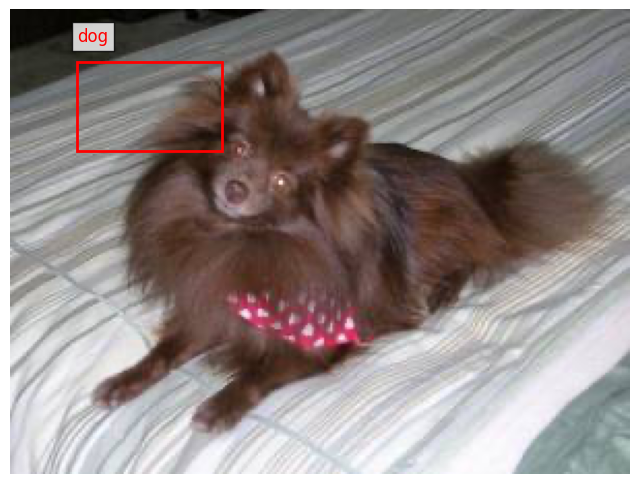

In [13]:
def predict_and_visualize(image_path, model, transform, label_map):
    """
    Predict bounding box and class label for a single image and display the results.

    Args:
        image_path (str): Path to the image file.
        model (nn.Module): Trained object detection model.
        transform (Compose): Transformations to apply to the image.
        label_map (dict): Mapping of label indices to class names.
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    input_image = transform(image).unsqueeze(0)  # Add batch dimension
    input_image = input_image.cuda() if T.cuda.is_available() else input_image

    # Set the model to evaluation mode
    model.eval()
    with T.no_grad():
        predicted_bboxes, predicted_classes = model(input_image)

    # Extract predictions
    bbox = predicted_bboxes[0].cpu().numpy()  # Bounding box coordinates
    class_index = T.argmax(predicted_classes, dim=1).item()  # Class index
    class_label = label_map[class_index]  # Class label

    # Convert normalized bbox coordinates to absolute pixel values
    image_width, image_height = image.size
    xmin = int(bbox[0] * image_width)
    ymin = int(bbox[1] * image_height)
    xmax = int(bbox[2] * image_width)
    ymax = int(bbox[3] * image_height)

    # Display the image with the bounding box and label
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)
    ax.add_patch(
        patches.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            linewidth=2, edgecolor='red', facecolor='none'
        )
    )
    ax.text(
        xmin, ymin - 10, f'{class_label}',
        color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.8)
    )
    plt.axis('off')
    plt.show()

# Define the label map (reverse of the label-to-integer map used in training)
label_map = {0: 'cat', 1: 'dog'}

# Path to a test image
test_image_path = '/content/drive/MyDrive/cats-dogs-annotate/images/Cats_Test18.png'

# Call the function to predict and visualize
predict_and_visualize(test_image_path, model, transform, label_map)